In [162]:
import numpy as np 
from scipy import stats
import scipy
import math
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [109]:
# Skeleton definition
NUI_SKELETON_POSITION_COUNT = 20

NONE = -1
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

nui_skeleton_names = ( \
    'HIP_CENTER', 'SPINE', 'SHOULDER_CENTER', 'HEAD', \
    'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', \
    'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT', \
    'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', \
    'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT' )

nui_skeleton_conn = ( \
    NONE, \
    HIP_CENTER, \
    SPINE, \
    SHOULDER_CENTER, \
    # Left arm 
    SHOULDER_CENTER, \
    SHOULDER_LEFT,  \
    ELBOW_LEFT,  \
    WRIST_LEFT,  \
    # Right arm 
    SHOULDER_CENTER,  \
    SHOULDER_RIGHT,  \
    ELBOW_RIGHT,  \
    WRIST_RIGHT,  \
    # Left leg 
    HIP_CENTER,  \
    HIP_LEFT,  \
    KNEE_LEFT,  \
    ANKLE_LEFT,  \
    # Right leg 
    HIP_CENTER,  \
    HIP_RIGHT,  \
    KNEE_RIGHT,  \
    ANKLE_RIGHT,  \
)


In [110]:
def load_dataset(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/data.mat')
    else:
        ex = scipy.io.loadmat(file)
        
    return ex['data'],ex['labels'],ex['individuals']


In [147]:
def load_validation(file=None):
    """
      Returns the small data for validation
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/validation_data.mat')
    else:
        ex = scipy.io.loadmat(file)
#         ,ex['train_indexes'],ex['test_indexes'],ex['model_nb'],ex['accur_nb'],ex['accur_lg']
    return ex['data_small'],ex['labels_small'],ex['individuals_small']

In [112]:
def log_normpdf(x, mu, sigma):
    """
      Computes the natural logarithm of the normal probability density function
      
    """
    return scipy.stats.norm.logpdf(x,mu,sigma)

In [113]:
def normalize_logprobs(log_probs):
    """
       Returns the log prob normalizes so that when exponenciated
       it adds up to 1 (Useful to normalizes logprobs)
    """
    m = np.max(log_probs)
    return log_probs - m - np.log(np.sum(np.exp(log_probs - m)))


#### Functions to implement

In [114]:
def fit_gaussian(X, W=None):
    """
      Compute the mean and variance of X, 
      You can ignore W for the moment
    """
    #mean
    mean = np.mean(X)
    #variance
    variance = np.var(X)
    return (mean, variance)


In [115]:
def my_cov(x,y,w):
    """
      Useful function for fit_linear_gaussian
    """
    return np.sum(w*x*y)/np.sum(w)-np.sum(w*x)*np.sum(w*y)/np.sum(w)/np.sum(w)


In [116]:
def fit_linear_gaussian(Y,X,W = None):
    """
    Input:
      Y: vector of size D with the observations for the variable
      X: matrix DxV with the observations for the parent variables
                 of X. V is the number of parent variables
                 thus X has observations of Y's parents
      W: vector of size D with the weights of the instances (ignore for the moment)
      
    Outout:
    
       The betas and sigma
    """
    
        # no parents
    len_betas = X.shape[1]+1;
    b = np.zeros(len_betas)
    A = np.zeros((len_betas,len_betas))
    betas = np.zeros(len_betas)
    sigma = 0
    
    # FORMAT b , from b = Ax..
    
    # Constract vector b .. the interest variable.
    for i in range(len_betas):
        if i==0:
            b[0] = np.mean(Y)        
        else:
            b[i] = np.mean(X[:,i-1]*Y)
    
    # Format A matrix.
    A[0,0] = 1
    # first row and first col of A
    for i in range(1,len_betas):
        A[0,i] = A[i,0] = np.mean(X[:,i-1])
        
    # For the rest
    for i in range(1,len_betas):
        for j in range(1,len_betas):
            A[i,j] = np.mean(X[:,i-1]*X[:,j-1])
    # to find betas we can use linear equation: b = Ax=> x = inverse(A)b
    betas = np.linalg.solve(A,b)
    
    # sigmas and 
    w = np.ones(X.shape[0])
    sigma_set = 0 
    for i in range(1,X.shape[1]+1):
        for j in range(1,X.shape[1]+1):
            sigma_set += betas[i]*betas[j]*my_cov(X[:,i-1],X[:,j-1],w)
    sigma = np.sqrt(abs(my_cov(Y, Y , w) - sigma_set))
    return (betas,sigma)

In [117]:
def prior_prob(labels):
    
    unique_labels =np.unique(labels)
    prior = np.zeros(unique_labels.size)
    for i in range(unique_labels.size):
        prior[i] = (np.size(labels[labels == unique_labels[i]])/labels.size)
    return prior

In [118]:
def learn_model(dataset, labels, G=None):
    """
    Input:
     dataset: The data as it is loaded from load_data
     labels:  The labels as loaded from load_data
     Graph:   (optional) If None, this def should compute the naive 
           bayes model. If it contains a skel description (pe 
           nui_skeleton_conn, as obtained from skel_model) then it should
           compute the model using the Linear Gausian Model

    Output: the model
     a (tentative) structure for the output model is:
       model.connectivity: the input Graph variable should be stored here 
                           for later use.
       model.class_priors: containing a vector with the prior estimations
                           for each class
       model.jointparts[i] contains the estimated parameters for the i-th joint

          For joints that only depend on the class model.jointparts(i) has:
            model.jointparts(i).means: a matrix of 3 x #classes with the
                   estimated means for each of the x,y,z variables of the 
                   i-th joint and for each class.
            model.jointparts(i).sigma: a matrix of 3 x #classes with the
                   estimated stadar deviations for each of the x,y,z 
                   variables of the i-th joint and for each class.

          For joints that follow a gausian linear model model.jointparts(i) has:
            model.jointparts(i).betas: a matrix of 12 x #classes with the
                   estimated betas for each x,y,z variables (12 in total) 
                   of the i-th joint and for each class label.
            model.jointparts(i).sigma: as above
            https://www.youtube.com/watch?v=PErqizZqLjI
    """
    # estimate priori probablity of classes and create model object
    
    prioriProb = prior_prob(labels)
    model = Model(G, prioriProb)
    
    # for each classes 
    cls = np.array([1,2,3,8],np.int32)
    for cl in np.nditer(cls):
        indexs = np.where(labels == cl)
        cl_data = dataset[:,:,indexs[0]]
        cl_index = np.where(cls == cl)[0][0] # for indexing purpose
        # we have 3 coordinate for each joints(20 Jnts)
        for jointCord in range(dataset.shape[0]): 
            # naive bayes
            if G is None or G[jointCord] == -1:
                (mean_x, variance_x) = fit_gaussian(cl_data[jointCord,0,:]) #x
                (mean_y, variance_y) = fit_gaussian(cl_data[jointCord,1,:]) #y
                (mean_z, variance_z) = fit_gaussian(cl_data[jointCord,2,:]) #z
                mean = np.array([mean_x,mean_y,mean_z])
                variance = np.array([variance_x, variance_y, variance_z])
                model.jointParts(jointCord,cl_index,mean = mean.T,variance = variance.T)
                # linear gaussian
            else:
                (betas_x, sigma_x) = fit_linear_gaussian(cl_data[jointCord,0,:].T, cl_data[G[jointCord],:,:].T) #x
                (betas_y, sigma_y) = fit_linear_gaussian(cl_data[jointCord,1,:].T, cl_data[G[jointCord],:,:].T) #y
                (betas_z, sigma_z) = fit_linear_gaussian(cl_data[jointCord,2,:].T, cl_data[G[jointCord],:,:].T) #z
                betas = np.zeros(betas_x.shape[0]*3)
                for ia in range(betas_x.shape[0]):
                    betas[ia] = betas_x[ia]
                    betas[betas_x.shape[0]+ia] = betas_y[ia]
                    betas[2*betas_x.shape[0]+ia] = betas_z[ia]
                sigma = np.array([sigma_x, sigma_y,sigma_z])
                model.jointParts(jointCord,cl_index,betas = betas.T,sigma = sigma.T)
        
    return model

In [119]:
class Model:
    def __init__(self,connectivity,priori_prob):
        self.mean = np.zeros((20,3,4))
        self.variance = np.zeros((20,3,4))
        self.betas = np.zeros((20,12,4))
        self.sigma= np.zeros((20,3,4))
        self.connectivity = connectivity
        self.priori_prob = priori_prob
        
    # Input graph variables
    def getConnectivity(self):
        return self.connectivity 
    
    # Priori probablity of each class
    def getClass_priori(self):
        return self.priori_prob  
    
    # estimated parameters of each joint
    def jointParts(self, index,cl,mean = None, variance  = None, betas  = None, sigma  = None):

        self.index = index
        if self.connectivity is None or self.connectivity[index] == -1:
            self.mean[index,:,cl] = mean # matrix of 20 x 3 x #classes
            self.variance[index,:,cl] = variance # matrix of 20 x 3 x #classes
        else:
            self.betas[index,:,cl] = betas # matrix of 20 x 12 x #classes
            self.sigma[index,:,cl] = sigma # matrix of 20 x 3 x #classes
                

In [120]:
def classify_instances(instances, model):
    """    
    Input
       instance: a 20x3x#instances matrix defining body positions of
                 instances
       model: as the output of learn_model

    Output
       probs: a matrix of #instances x #classes with the probability of each
              instance of belonging to each of the classes

    Important: to avoid underflow numerical issues this computations should
               be performed in log space
    """
#     model = learn_model(data, labels)
    probs = np.zeros((instances.shape[2], model.getClass_priori().shape[0])) 
    for inst in range(instances.shape[2]):
        example = instances[:,:,inst]
        probs[inst,:]= compute_logprobs(example, model)
    return probs

In [121]:
def compute_logprobs(example, model):
    """
       Input
           instance: a 20x3 matrix defining body positions of one instance
           model: as given by learn_model
       Output
           l: a vector of len #classes containing the loglikelihhod of the 
              instance
    """
    priori = model.getClass_priori()
    G = model.getConnectivity()
    likelihood = np.zeros(priori.shape[0]) # len #classes
    for cl in range(likelihood.shape[0]):
        #compute the loglikelihood of the instance
        p = np.log(priori[cl])
        for i in range(example.shape[0]):
            if G is None or G[i] == -1:
                # naive bayes 
                mean = model.mean[i,:,cl]
                variance = model.variance[i,:,cl]
                for coor in range(mean.shape[0]):
                    p = p + log_normpdf(example[i,coor], mean[coor], np.sqrt(variance[coor]))
            else:
                # linear Gaussian
                betas = model.betas[i,:,cl].reshape(example.shape[1],example.shape[1]+1) # (3X4)
                sigma = model.sigma[i,:,cl]
                for bi in range(betas.shape[0]):
                    mu = betas[bi,0]
                    for bj in range(betas.shape[1]-1):
                        mu = mu + betas[bi,bj+1]*example[G[i]][bj]
                    p = p + log_normpdf(example[i,bi], mu, np.sqrt(sigma[bi]))
        likelihood[cl] = p
    return np.exp(normalize_logprobs(likelihood))


In [227]:
data, labels, individuals = load_dataset()
# valid_data, valid_labels, valid_individuals = load_validation()
prev = 0

# change model to 1 for linear Gaussian 
# change model to 0 for naive bayes
model = 0
acc_plot = []
if model == 0:
    conn = None
    print("Naive Bayes model")
else:
    conn = nui_skeleton_conn
    print("Linear Gaussian model")
for i in range(3,15):
    if prev ==(math.ceil(30/i)):
        continue
    print (math.ceil(30/i),"-fold")
    prev = math.ceil(30/i)
    j=1
    count_div = 0
    acc_sum = 0
    while(j<30-i):
        # divide the dataset into k fold by considering individuals.
        iits_inter = np.where(individuals >= j)
        individuals_new = individuals[iits_inter[0]]
        iits = np.where(individuals_new < (i+j))
        iitr_inter = np.where(individuals < j)
        individualsr_new = individuals[iitr_inter[0]]
        iitr = np.where(individuals >= (i+j))
        training_ind = np.concatenate((iitr[0], iitr_inter[0]), axis=None)
        # Learn the model by using the training set
    
        model_out = learn_model(data[:,:,training_ind], labels[training_ind], conn)
        # Classify the testing data by using the model learned
        
        probabilities = classify_instances(data[:,:,iits[0]], model_out)
        predicted = np.zeros(probabilities.shape[0])
        accuracy=0
        # Accuracy Calculation
        
        actual=np.squeeze(labels[iits[0],0])
        for acc_itr in range(probabilities.shape[0]):
            xx = np.where(probabilities[acc_itr,:] == np.max(probabilities[acc_itr,:]))
            predicted[acc_itr]=xx[0]
            if(predicted[acc_itr]==3.0):
                predicted[acc_itr]=8.0
            else:
                predicted[acc_itr]+=1
            diffrence= predicted[acc_itr]-actual[acc_itr]
            if(diffrence==0):
                accuracy+=1
        acc_sum += accuracy/(probabilities.shape[0])
        count_div +=1
        j = j+i
    total_acc = acc_sum/count_div
    print ("++++++++++++++++++++++++++++++++++++++")
    print("Accuracy ",total_acc)
    print ("++++++++++++++++++++++++++++++++++++++")
    acc_plot.append(total_acc)

Naive Bayes model
10 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9644592040331289
++++++++++++++++++++++++++++++++++++++
8 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9522351754675127
++++++++++++++++++++++++++++++++++++++
6 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9647539660656994
++++++++++++++++++++++++++++++++++++++
5 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9553077394829105
++++++++++++++++++++++++++++++++++++++
4 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9741624103986554
++++++++++++++++++++++++++++++++++++++
3 -fold
++++++++++++++++++++++++++++++++++++++
Accuracy  0.9748752014806383
++++++++++++++++++++++++++++++++++++++


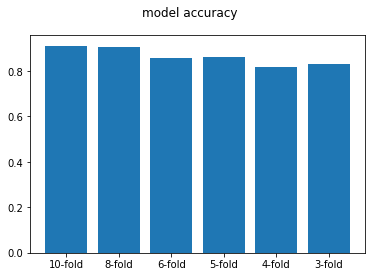

In [225]:
plt.figure()
plt.bar(["10-fold","8-fold","6-fold","5-fold","4-fold","3-fold"], acc_plot)
plt.suptitle('model accuracy ')
plt.show()